In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_BEGPDC.yml")

In [3]:
csrTF = False
#evalElement = "PENT"
evalElement = "BEGPDC"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e5,
)


#tao.cmd("set ele * space_charge_method = slice")
#tao.cmd("set ele * space_charge_method = fft_3d")


# activeSettings = importedDefaultSettings | {
#     # "S1EL_xOffset" : 0.00,  
#     # "S1EL_yOffset" : 0.0,  
#     # #"S2EL_xOffset" : 0.002,  
#     # "S2EL_yOffset" : 0.0,  
#     # "S2ER_xOffset" : 0.0,  
#     # "S2ER_yOffset" : 0.0,  
#     # "S1ER_xOffset" : 0.0,  
#     # "S1ER_yOffset" : 0.0,

#     # #"XC1FFkG" : 0.2321150061,


#     # #Sextupole compensated, CSR off
#     # "S2EL_xOffset" : 0.002, 
#     # "XC1FFkG" : 0.19,

# }
# setLattice(tao, **activeSettings)



# ffOverride = finalFocusSolver(tao, 
#              ele = "PENT",
#              s_offset = 0,
#              targetBetaX = 0.1,
#              targetAlphaX = 0.0,
#              targetBetaY = 0.1,
#              targetAlphaY = 0,
#              verbose = True
#              );

# importedDefaultSettings = importedDefaultSettings | ffOverride

setLattice(tao, **importedDefaultSettings)

#Rescale charge
# newCharge = 1e-12
# trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
# P = getBeamAtElement(tao, "L0AFEND")
# print(f"""\n\n\nAs imported charge: {P.charge}""")
# P.charge = newCharge
# makeBeamActiveBeamFile(P)
# tao.cmd('reinit beam')

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))
print(f"""New charge: {PInit.charge}""")

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting
New charge: 1.6000000000000005e-09


In [4]:
trackBeam(tao, 
          **importedDefaultSettings,
          verbose = True
         )

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Also setting BC14 energy = 4.5 GeV, from 4.420464842149227 GeV
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Also setting BC20 energy = 10.0 GeV, from 9.914501270469462 GeV
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Set track_end = MFFF
Tracking!
Beam centered at MFFF written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = MFFF, track_end = end
Tracking!
trackBeam() exiting


In [5]:
P = getBeamAtElement(tao, evalElement)


if bunchCount == 1:
    PDrive = P.copy()
elif bunchCount == 2:
    PDrive, PWitness = getDriverAndWitness(P)


savedData = getBeamSpecs(P, targetTwiss = evalElement)

savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [6]:

(getBeamAtElement(tao, "PENT")).write("beams/optimizerRunningBestBeam_PENT.h5")
savedData

{'PDrive_median_x': 3.940998184520881e-06,
 'PDrive_median_y': 3.550498148934904e-06,
 'PDrive_median_xp': 3.0980812512338675e-08,
 'PDrive_median_yp': 1.9513603777195937e-06,
 'PDrive_sigmaSI90_x': 1.7063624464951644e-05,
 'PDrive_sigmaSI90_y': 1.427950261012546e-05,
 'PDrive_sigmaSI90_z': 1.7346856911031126e-05,
 'PDrive_sigmaSI90_xp': 2.4954102269849343e-05,
 'PDrive_sigmaSI90_yp': 3.816941392113284e-05,
 'PDrive_emitSI90_x': 8.750952179733273e-06,
 'PDrive_emitSI90_y': 1.0530105525934271e-05,
 'PDrive_norm_emit_x': 1.6379597979059963e-05,
 'PDrive_norm_emit_y': 1.5114555867561302e-05,
 'PDrive_charge_nC': 1.5996480000000006,
 'lostChargeFraction': 0.00021999999999999797}

In [7]:

if bunchCount == 2:
    print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")
    
    print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
    print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
if bunchCount == 2:
    print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_z"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
if bunchCount == 2: 
    print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g} × {1e6 * PDrive["sigma_y"] :.3g} × {1e6 * PDrive["sigma_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g} × {1e6 * PWitness["sigma_y"] :.3g} × {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - implied by 90% charge
Driver emittance: 	8.75 × 10.5 um-rad
Driver sigma_x,y,z: 	17.1 × 14.3 × 17.3 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	16.4 × 15.1 um-rad
Driver sigma_x,y,z: 	25.3 × 18.8 × 21.4 um


Drive:


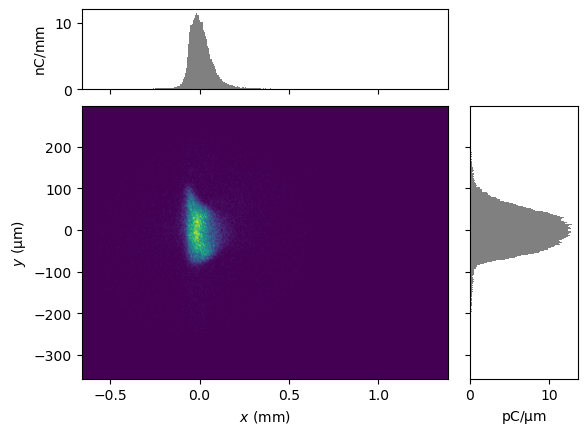

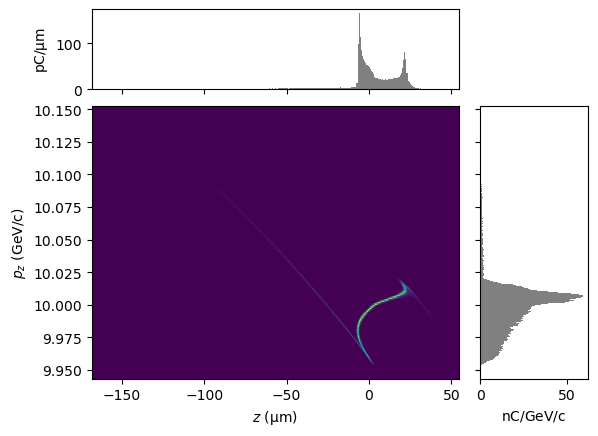

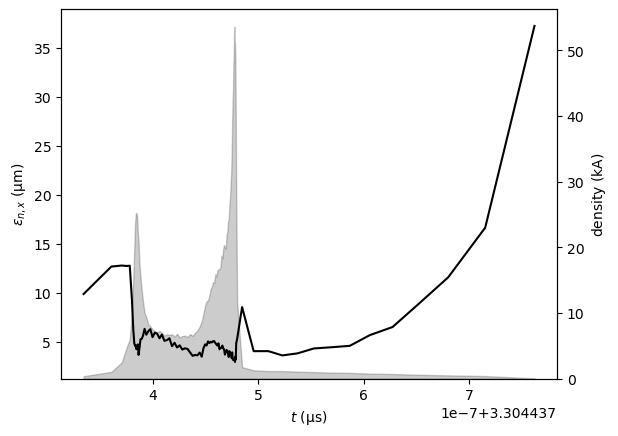

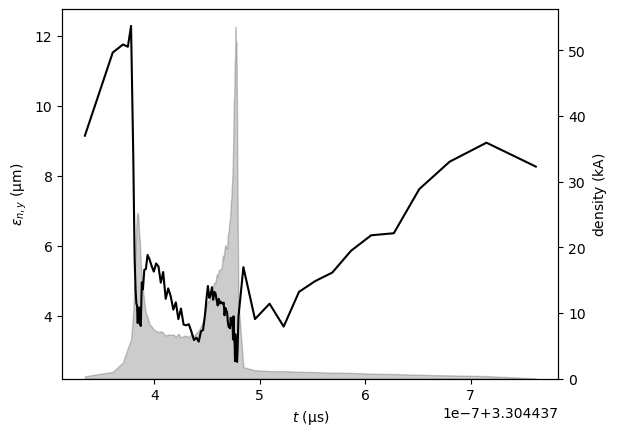

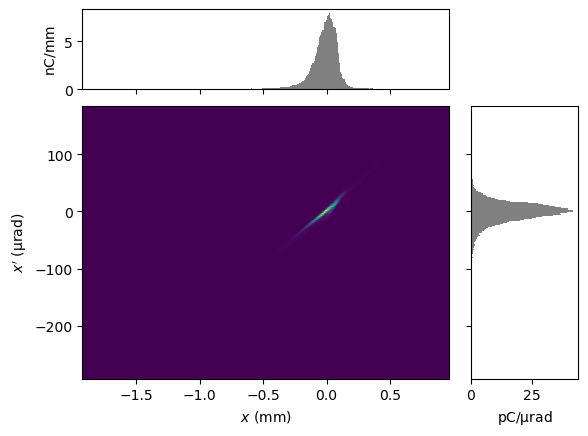

In [31]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
if bunchCount == 2:
    print("Witness:")
    display(plotMod(PWitness, 'x', 'y',  bins=300))
    
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
display(slicePlotMod(P, 'norm_emit_y', slice_key = "t", n_slice=100))

display(plotMod(P, 'x', 'xp', bins=300))
plt.clf()

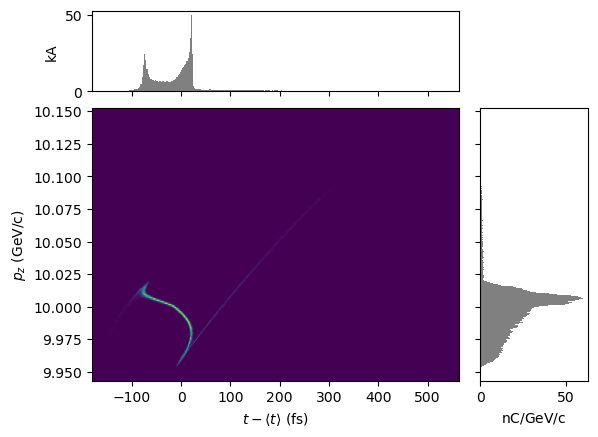

In [9]:
display(plotMod(PDrive, 'delta_t', 'pz', bins=300))

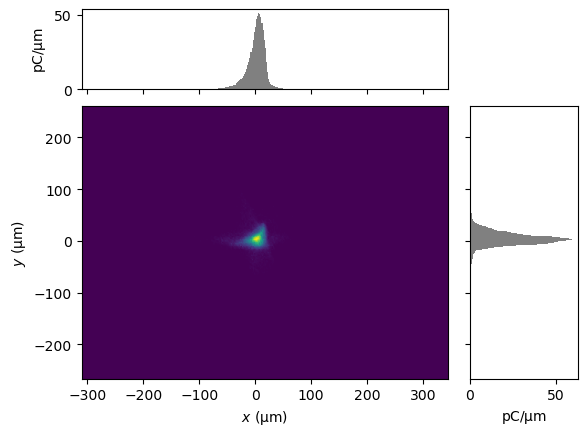

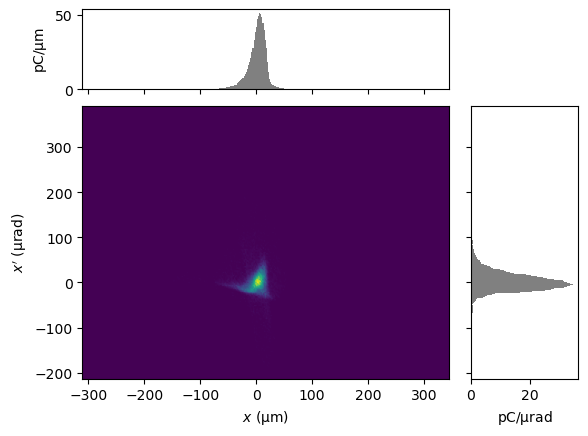

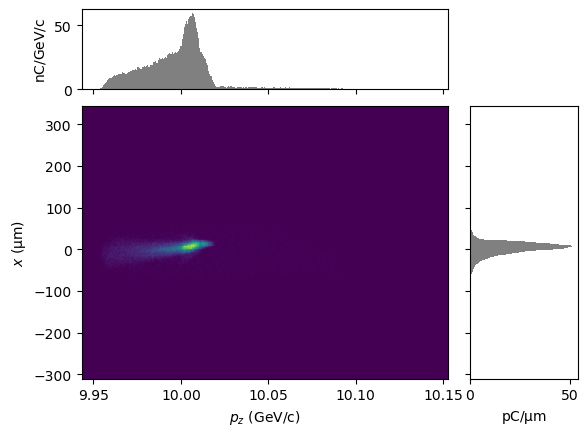

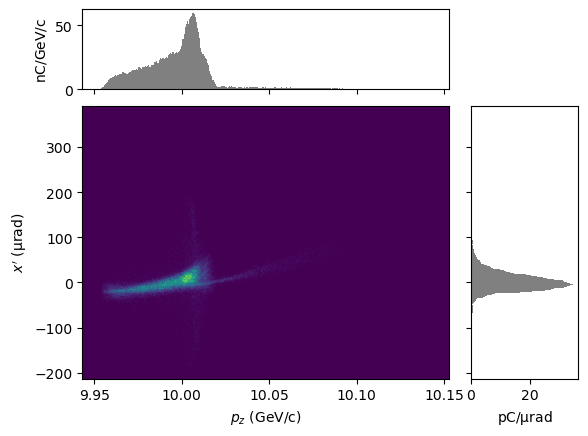

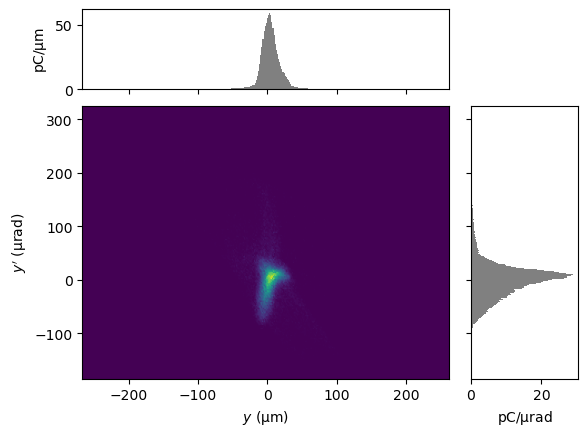

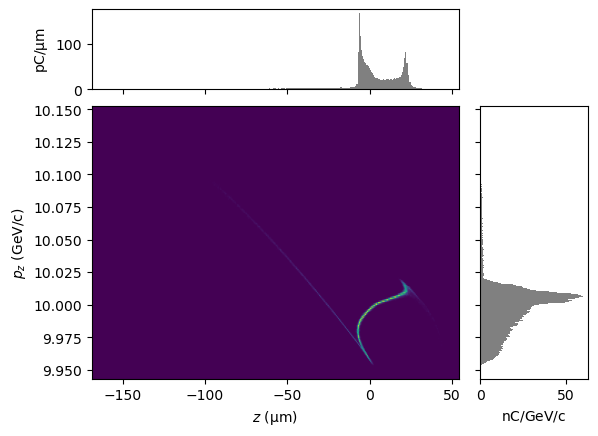

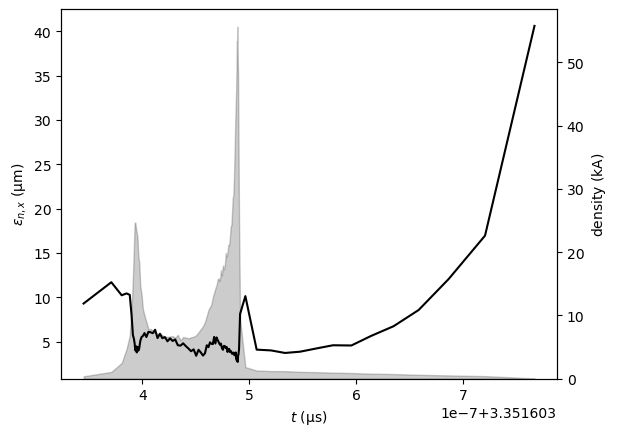

In [10]:
display(plotMod(PDrive, 'x', 'y',  bins=300))

display(plotMod(PDrive, 'x', 'xp', bins=300))
display(plotMod(PDrive, 'pz', 'x', bins=300))
display(plotMod(PDrive, 'pz', 'xp', bins=300))

display(plotMod(PDrive, 'y', 'yp', bins=300))
display(plotMod(PDrive, 'z', 'pz', bins=300))
display(slicePlotMod(PDrive, 'norm_emit_x',n_slice=100))

## Further study at other elements

In [11]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [12]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [13]:
P = getBeamAtElement(tao, "PR10571")
#PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.0075549176229788, 1.0065856107449864

System emit:  2.3261958026786357e-06, 1.6992809621946473e-06


In [14]:
P = getBeamAtElement(tao, "BEGBC20")
#PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")


System BMAG:  1.153284833927416, 1.2767881052525052

System emit:  3.826126692927293e-06, 1.6694366877650402e-06


In [15]:
P = getBeamAtElement(tao, "MFFF")
#PDrive, PWitness = getDriverAndWitness(P)
PDrive = P


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 9.558805920872746, 12.52544803104172
Drive alpha x / y: -1.25343336319992, -1.1078481021957642

System BMAG:  1.3386468388773214, 1.3527616237212632

System emit:  3.948197344608587e-06, 2.4288141332236322e-06


In [16]:
P = getBeamAtElement(tao, "PENT")
#PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

#print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
#print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 20.97920191445536, 1.143846663082562
System alpha x / y: -4.077855697342291, -1.0784738672781926
System BMAG:  21.18927791210568, 1.6166167362522927

System emit:  3.913210343271777e-06, 2.4260160033840205e-06


PR10571


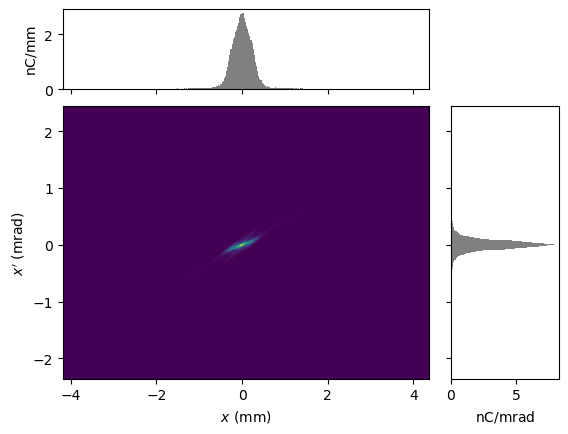

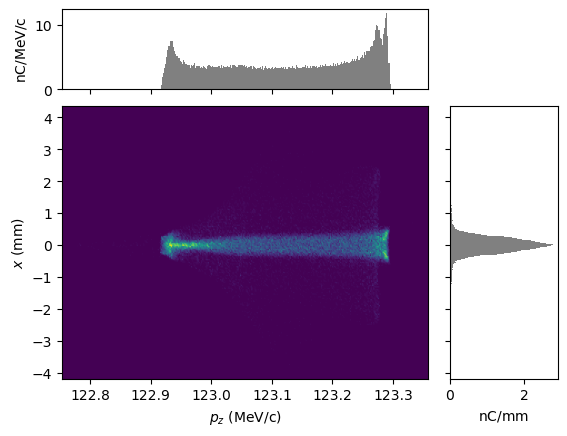

BEGBC20


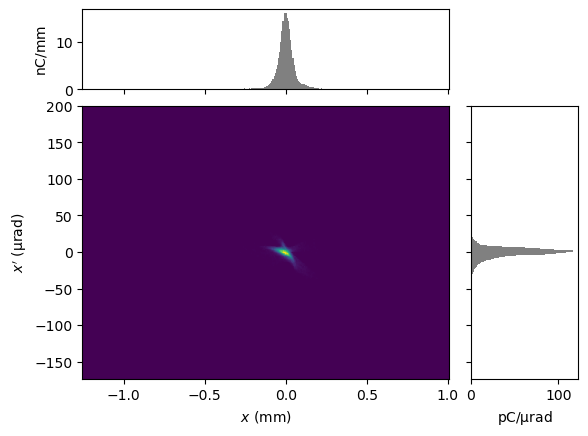

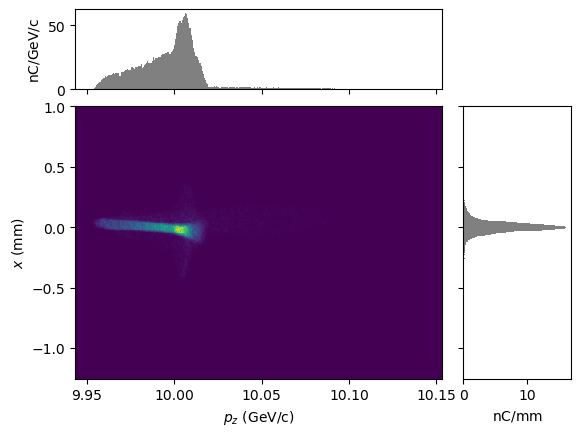

MFFF


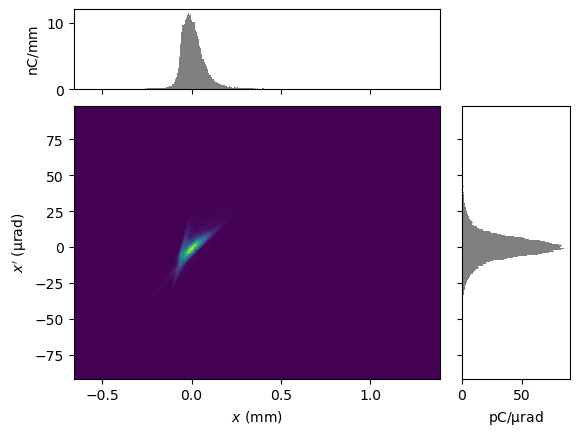

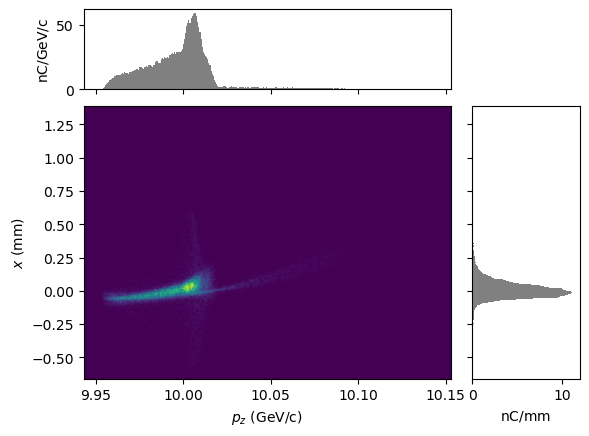

PENT


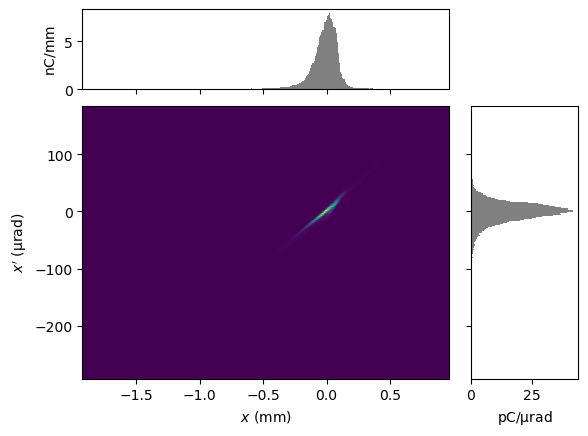

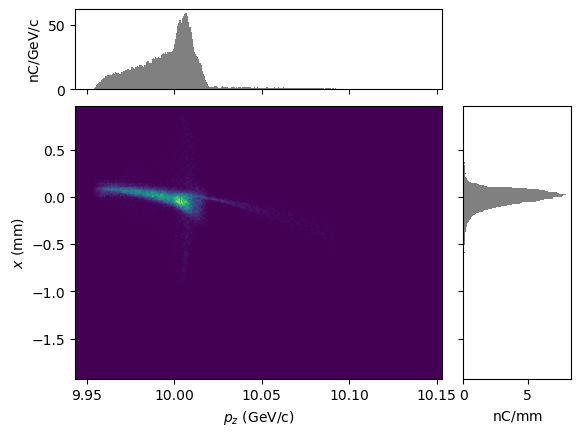

In [17]:

for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    #PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(P, 'x', 'xp',  bins=300))
    display(plotMod(P, 'pz', 'x',  bins=300))

# Check beam specs at treaty points

In [18]:
print("DL10")
getMatrix(tao,"LH10END", "BEGL1F",print=True);
print("BC11")
getMatrix(tao,"BEGBC11_1", "BEGL2F",print=True);
print("BC14")
getMatrix(tao,"ENDL2F", "BEGL3F_1",print=True);
print("BC20")
getMatrix(tao,"BEGBC20", "MFFF",print=True);

DL10


4.371024,-1.089037,0.000000,0.000000,0.000000,0.000000
-0.938919,0.462710,-0.000000,-0.000000,0.000000,-0.000000
0.000000,0.000000,-0.716651,-2.107302,0.000000,0.000000
0.000000,0.000000,-0.023472,-1.464398,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,1.000000,-0.006136
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC11


5.503387,-24.775546,0.000000,0.000000,0.000000,-0.000000
-0.203411,1.097438,-0.000000,-0.000000,0.000000,0.000000
-0.000000,0.000000,0.353439,2.781447,0.000000,0.000000
0.000000,-0.000000,-0.601774,-1.906419,0.000000,-0.000000
-0.000000,0.000000,-0.000000,-0.000000,1.000000,0.046019
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC14


-0.008002,17.783581,-0.000000,0.000000,0.000000,0.000007
-0.056770,1.195609,-0.000000,0.000000,0.000000,0.000001
-0.000000,0.000000,-1.165446,35.842067,0.000000,-0.000000
0.000000,0.000000,-0.003119,-0.762114,0.000000,0.000000
-0.000000,-0.000016,0.000000,-0.000000,1.000000,0.036014
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC20


-1.420934,-5.181772,0.009101,-0.043277,0.000000,0.016574
-0.170943,-1.325728,0.019399,0.129067,0.000000,0.002202
-0.042615,-0.201149,-0.725932,-3.689948,0.000000,-0.004687
0.028075,0.085255,-0.132085,-2.046162,0.000000,0.002452
0.000268,-0.010471,0.002700,0.020871,1.000000,-0.007866
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [19]:
P = getBeamAtElement(tao, "L0BFEND")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""SI90 emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")
print(f"""norm_emit: {1e6 * P["norm_emit_x"]}, {1e6 * P["norm_emit_y"]} um-rad""")

E: 0.12312282148965153 GeV 
sig_z: 568.026056666026 um
sig_E: 0.0855947878734357 %


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:445: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


SI90 emittance: 3.608135397791324, 2.6611855902589014 um-rad
norm_emit: 6.58214067681437, 5.1151201469394385 um-rad


In [20]:
P = getBeamAtElement(tao, "BEGL2F")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 0.33186595478624975 GeV 
sig_z: 328.12784148649945 um
sig_E: 0.5091684130158073 %


In [21]:
P = getBeamAtElement(tao, "BEGL3F_1")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 4.500472797678112 GeV 
sig_z: 18.607514870778854 um
sig_E: 0.8588120548319267 %


In [22]:
P = getBeamAtElement(tao, "BEGBC20")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")

E: 9.997955312944956 GeV 
sig_z: 18.592381059217377 um
sig_E: 0.17095014252870513 %
emittance: 10.020109686830946, 3.0227694984308804 um-rad


In [23]:
P = getBeamAtElement(tao, "PENT")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 9.997955695658087 GeV 
sig_z: 17.381206391619738 um
sig_E: 0.17094394805784466 %


In [24]:
importedDefaultSettings

{'QA10361kG': -3.1976079537,
 'QA10371kG': 3.1129092742,
 'QE10425kG': -6.8469996218,
 'QE10441kG': 1.5057761462,
 'QE10511kG': 7.0138622173,
 'QE10525kG': -5.3942250594,
 'B1EkG': 7.533,
 'B2EkG': -10.942,
 'B3EkG': 3.409,
 'Q1EkG': 161.311,
 'Q2EkG': -154.229,
 'Q3EkG': 110.217,
 'Q4EkG': 132.268,
 'Q5EkG': -23.373,
 'Q6EkG': -142.271,
 'symmetricSextupoleStrengths': True,
 'S1ELkG': 1408.4410969389,
 'S2ELkG': -2507.6265099827,
 'S3ELkG': -1472.2407416531,
 'S3ERkG': -1019.323,
 'S2ERkG': -2049.489,
 'S1ERkG': 804.871,
 'Q5FFkG': -60.5546926848,
 'Q4FFkG': -64.0401152798,
 'Q3FFkG': 127.1589877449,
 'Q2FFkG': 134.5911205082,
 'Q1FFkG': -230.2615170162,
 'Q0FFkG': 120.414599031,
 'Q0DkG': -120.2325344016,
 'Q1DkG': 179.4600157156,
 'Q2DkG': -135.520670764,
 'S1EL_xOffset': -0.0007127346,
 'S1EL_yOffset': -0.0004405488,
 'S2EL_xOffset': -0.0008820556,
 'S2EL_yOffset': 0.0002384656,
 'S2ER_xOffset': 0.0007531158,
 'S2ER_yOffset': -0.0001341203,
 'S1ER_xOffset': 0.0027970897,
 'S1ER_yOf

L0AFEND


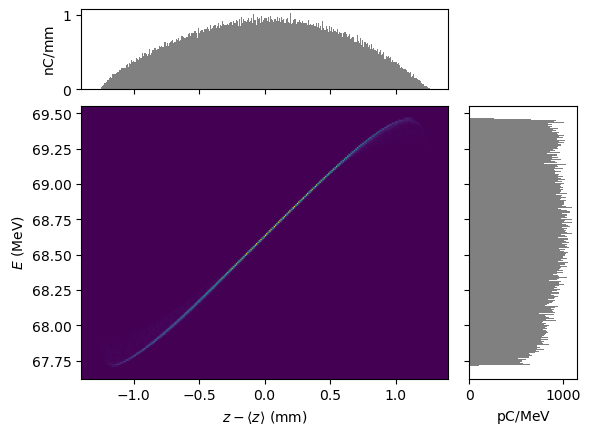

BEGL2F


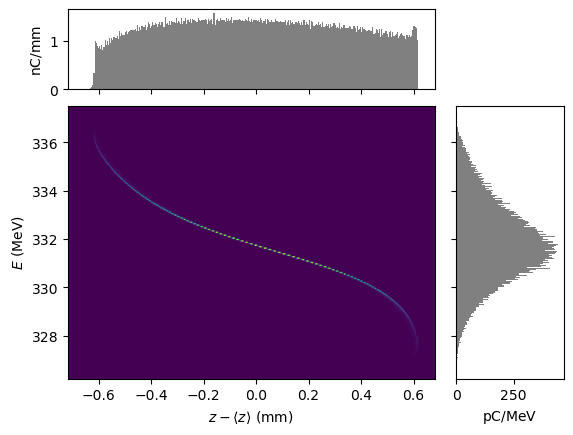

BEGL3F_1


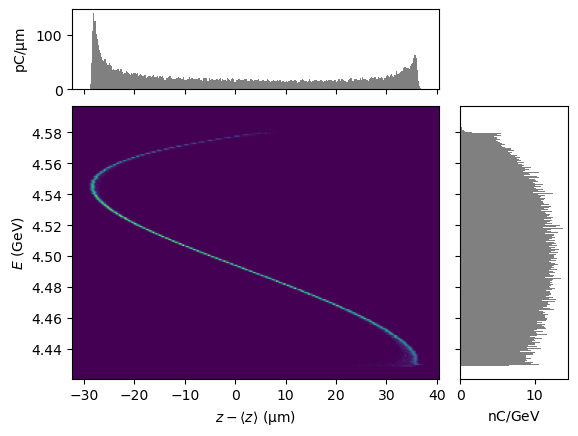

BEGBC20


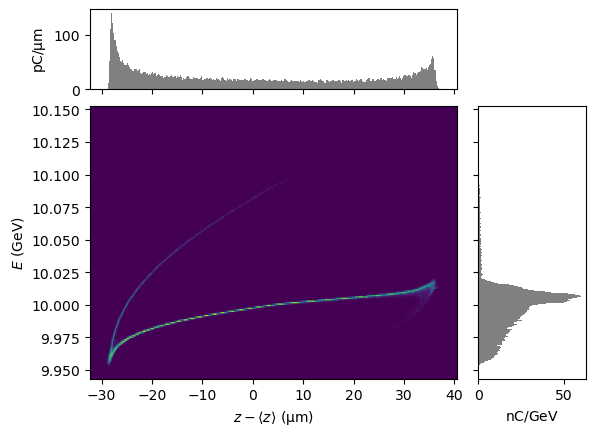

PENT


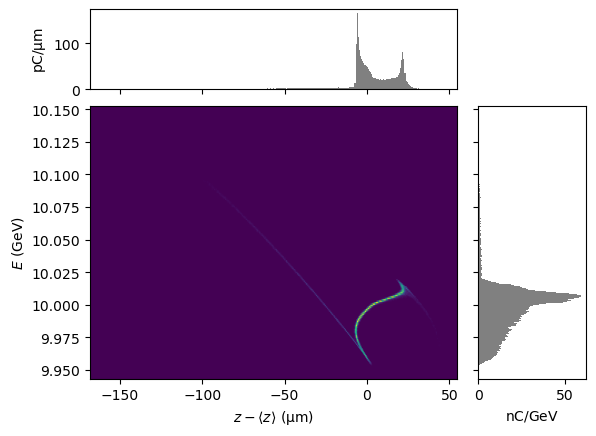

In [25]:
for activeElement in ["L0AFEND","BEGL2F","BEGL3F_1", "BEGBC20", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    display(plotMod(P, 'delta_z', 'energy',  bins=300))

In [26]:
# for activePhase in np.arange(-40, -25, 1):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )
    

In [27]:
# for activePhase in np.arange(-39.0, -33.0, 0.5):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     # activeElement = "BEGBC20"
#     # P = getBeamAtElement(tao, activeElement)
#     # print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     # display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     #print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     print(f"""{activeElement}: {1e6 * smallestIntervalImpliedSigma(P.t * 3e8, percentage=0.9)}""")
    
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

In [28]:
# for activePhase in np.arange(-75, 0, 5):
#     print(activePhase)
#     setLinacPhase(tao, "L3", activePhase)
#     setLinacGradientAuto(tao, "L3", 10e9 - 4.5e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )

In [29]:
getMatrix(tao, "BEGBC20", "PENT", print=True);

2.085325,7.918982,-0.021549,0.003414,0.000000,-0.023287
0.389759,1.958678,-0.016500,-0.090855,0.000000,-0.004783
-0.020088,-0.046600,0.280447,2.827980,0.000000,-0.001928
-0.124019,-0.387971,0.436638,7.961545,0.000000,-0.011095
0.000913,-0.007507,0.002551,0.018159,1.000000,-0.007869
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [30]:
?getMatrix

Signature: getMatrix(tao, start, end, order=1, print=False)
Docstring: Return zero or first order transport matrix from start to end. Optionally print in a human readable format
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function